In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
train_dir = './Worksite-Safety-Monitoring-Dataset/train'
test_dir = './Worksite-Safety-Monitoring-Dataset/test'
valid_dir = './Worksite-Safety-Monitoring-Dataset/valid'

In [3]:
train_safe_dir = './Worksite-Safety-Monitoring-Dataset/train/safe'
train_unsafe_dir = './Worksite-Safety-Monitoring-Dataset/train/unsafe'
test_safe_dir = './Worksite-Safety-Monitoring-Dataset/test/safe'
test_unsafe_dir = './Worksite-Safety-Monitoring-Dataset/test/unsafe'
valid_safe_dir = './Worksite-Safety-Monitoring-Dataset/valid/safe'
valid_unsafe_dir = './Worksite-Safety-Monitoring-Dataset/valid/unsafe'

In [4]:
safe_images = os.listdir(train_safe_dir)
unsafe_images = os.listdir(train_unsafe_dir)

print("Jumlah Gambar Safe", len(safe_images))
print("Jumlah Gambar Unsafe", len(unsafe_images))

safe_images_valid = os.listdir(valid_safe_dir)
unsafe_images_valid = os.listdir(valid_unsafe_dir)

print("Jumlah Gambar Safe", len(safe_images_valid))
print("Jumlah Gambar Unsafe", len(unsafe_images_valid))

Jumlah Gambar Safe 810
Jumlah Gambar Unsafe 810
Jumlah Gambar Safe 100
Jumlah Gambar Unsafe 100


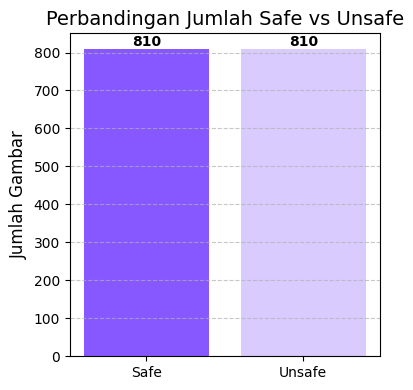

In [5]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Safe', 'Unsafe']
counts = [len(safe_images), len(unsafe_images)]
colors = ['#8758ff', '#dacbff']

plt.figure(figsize=(4, 4))
bars = plt.bar(categories, counts, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom',
             fontsize=10, fontweight='bold')

plt.title('Perbandingan Jumlah Safe vs Unsafe', fontsize=14)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Gambar 1.jpg: Shape = (640, 640, 3)
Gambar 10.jpg: Shape = (640, 640, 3)


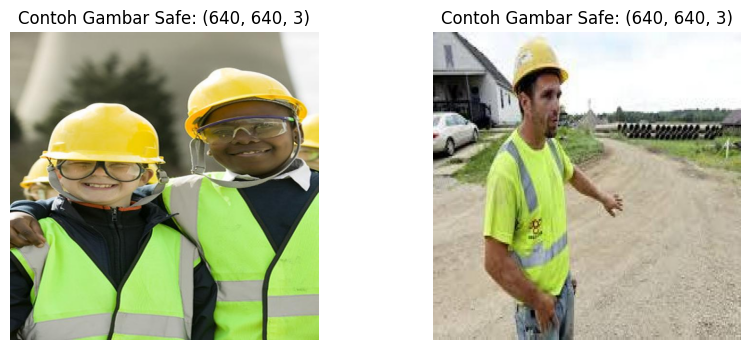

In [6]:
from PIL import Image

plt.figure(figsize=(10, 4))
for i, img_path in enumerate(safe_images[:2]):
    img = Image.open(os.path.join(train_safe_dir, img_path))
    plt.subplot(1, 2, i+1)
    img_array = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Contoh Gambar Safe: {img_array.shape}")
    print(f"Gambar {img_path}: Shape = {img_array.shape}")
plt.show()

Gambar 4.jpg: Shape = (640, 640, 3)
Gambar 5.jpg: Shape = (640, 640, 3)


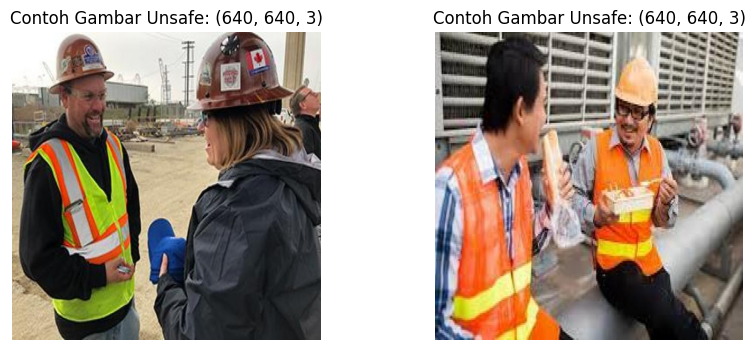

In [7]:
unsafe_images = sorted(
    os.listdir(train_unsafe_dir),
    key=lambda x: int(os.path.splitext(x)[0])
)

plt.figure(figsize=(10, 4))
for i, img_path in enumerate(unsafe_images[3:5]):
    img = Image.open(os.path.join(train_unsafe_dir, img_path))
    img_array = np.array(img)
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Contoh Gambar Unsafe: {img_array.shape}")
    print(f"Gambar {img_path}: Shape = {img_array.shape}")
plt.show()

In [8]:
train_datagen_noscale = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen_noscale = ImageDataGenerator()
valid_datagen_noscale = ImageDataGenerator()

In [10]:
def build_resnet_model_128(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)

    base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=x  # PENTING agar seluruh graph terhubung dari 'inputs'
    )
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs=outputs)
    return model


train_generator = train_datagen_noscale.flow_from_directory(
  train_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='binary',
  color_mode="rgb",
  shuffle=True
)

valid_generator = valid_datagen_noscale.flow_from_directory(
  valid_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='binary',
  color_mode="rgb",
  shuffle=True
)

model = build_resnet_model_128()
opt = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("models/best_resnet_model.keras", save_best_only=True)

history = model.fit(train_generator, validation_data=valid_generator, epochs=15, callbacks=[early_stop, checkpoint])

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5811 - loss: 0.8723

51/51 ━━━━━━━━━━━━━━━━━━━━ 409s 8s/step - accuracy: 0.5818 - loss: 0.8707 - val_accuracy: 0.6700 - val_loss: 0.6613
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7068 - loss: 0.6203

51/51 ━━━━━━━━━━━━━━━━━━━━ 379s 7s/step - accuracy: 0.7069 - loss: 0.6203 - val_accuracy: 0.7900 - val_loss: 0.5393
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7769 - loss: 0.4958

51/51 ━━━━━━━━━━━━━━━━━━━━ 378s 7s/step - accuracy: 0.7767 - loss: 0.4960 - val_accuracy: 0.8100 - val_loss: 0.4752
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7748 - loss: 0.4916

51/51 ━━━━━━━━━━━━━━━━━━━━ 423s 8s/step - accuracy: 0.7749 - loss: 0.4914 - val_accuracy: 0.8300 - val_loss: 0.4479
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7888 - loss: 0.4608

51/51 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - accuracy: 0.7888 - loss: 0.4610 - val_accuracy: 0.8400 - val_loss: 0.4427
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 286s 6s/step - accuracy: 0.8091 - loss: 0.4335 - val_accuracy: 0.8150 - val_loss: 0.4791
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8266 - loss: 0.3894

51/51 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.8267 - loss: 0.3895 - val_accuracy: 0.8300 - val_loss: 0.4384
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8236 - loss: 0.3747

51/51 ━━━━━━━━━━━━━━━━━━━━ 358s 7s/step - accuracy: 0.8236 - loss: 0.3747 - val_accuracy: 0.8100 - val_loss: 0.4167
Epoch 9/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8106 - loss: 0.4200

51/51 ━━━━━━━━━━━━━━━━━━━━ 417s 8s/step - accuracy: 0.8110 - loss: 0.4193 - val_accuracy: 0.8350 - val_loss: 0.4052
Epoch 10/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8509 - loss: 0.3532

51/51 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.8509 - loss: 0.3532 - val_accuracy: 0.8450 - val_loss: 0.3909
Epoch 11/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - accuracy: 0.8328 - loss: 0.3641 - val_accuracy: 0.8350 - val_loss: 0.3970
Epoch 12/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 281s 6s/step - accuracy: 0.8630 - loss: 0.3278 - val_accuracy: 0.8550 - val_loss: 0.3923
Epoch 13/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 282s 6s/step - accuracy: 0.8581 - loss: 0.3286 - val_accuracy: 0.8500 - val_loss: 0.3921
Epoch 14/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 282s 6s/step - accuracy: 0.8827 - loss: 0.2756 - val_accuracy: 0.8550 - val_loss: 0.4047
Epoch 15/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 280s 5s/step - accuracy: 0.8630 - loss: 0.3243 - val_accuracy: 0.8300 - val_loss: 0.3959


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add_1[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,375,941 (92.99 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

 Optimizer params: 525,316 (2.00 MB)

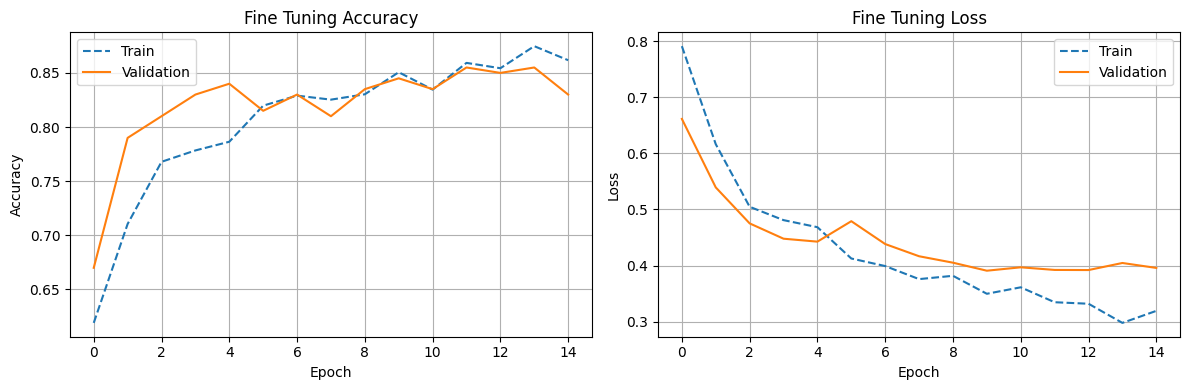

In [12]:
def plot_results_separated(hist):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], linestyle='--', label='Train')
        plt.plot(hist.history['val_accuracy'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], linestyle='--', label='Train')
        plt.plot(hist.history['val_loss'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

plot_results_separated(hist=history)

In [13]:
model.evaluate(valid_generator) #Evaluasi performa model

7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8432 - loss: 0.4119


[0.3909274637699127, 0.8450000286102295]

In [14]:
test_generator = test_datagen_noscale.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 200 images belonging to 2 classes.


In [15]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.8098 - loss: 0.4032
Test Loss: 0.4101
Test Accuracy: 0.8200


7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step


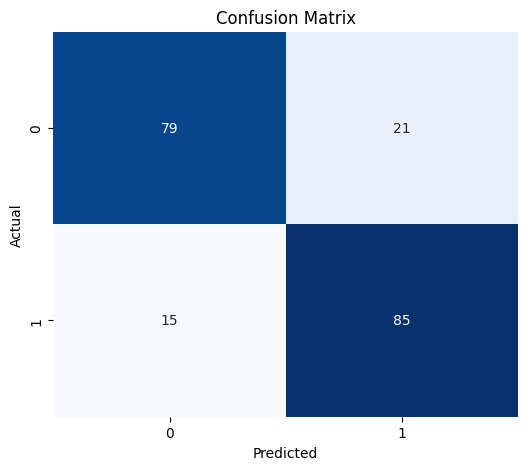

Accuracy Score: 0.82
Confusion Matrix:
[[79 21]
 [15 85]]
Classification Report:
              precision    recall  f1-score   support

        safe       0.84      0.79      0.81       100
      unsafe       0.80      0.85      0.83       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

test_generator.reset()

# Prediksi probabilitas dan ubah jadi label 0/1
pred_probs = model.predict(test_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Label sebenarnya
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_labels, pred_labels)

# Plot heatmap confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Evaluasi metrik
print("Accuracy Score:", accuracy_score(true_labels, pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))


In [17]:
model.save("modelku.h5")
model.save("modelku.keras")

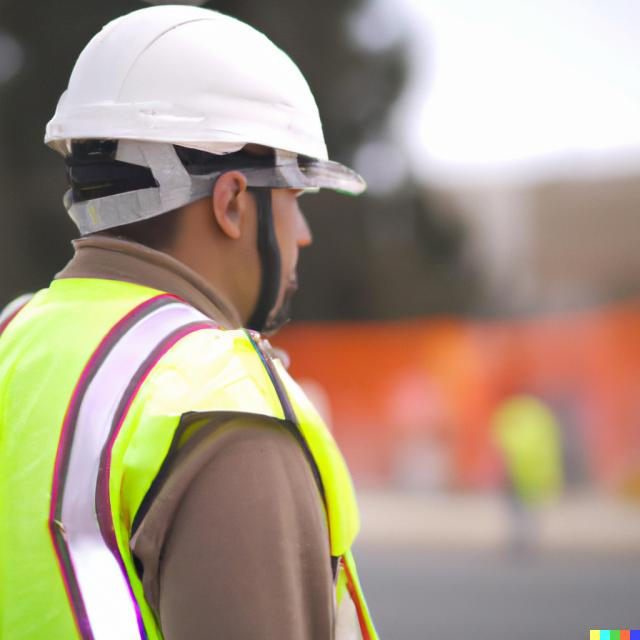

In [18]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image

img_size = (224, 224)  # ukuran standar ResNet50
class_names = ['safe', 'unsafe']  # ubah sesuai label datasetmu
# Path ke gambar
img_path = "./Worksite-Safety-Monitoring-Dataset/test/safe/1.jpg"

display(Image(img_path))

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        # Untuk binary classification dengan sigmoidv
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [19]:
img_array = get_img_array(img_path, size=img_size)

preds = model.predict(img_array)

confidence = preds[0][0]
confidence_real = preds[0][0] if preds[0][0] > 0.5 else 1 - preds[0][0]
class_names = ["safe", "unsafe"]
predicted_class_index = int(confidence > 0.5)
predicted_class = class_names[predicted_class_index]
print(f"Prediksi: {predicted_class} (confidence: {confidence_real:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediksi: safe (confidence: 0.9764)


In [20]:
for layer in model.layers:
    if "conv5_block3" in layer.name:
        print(layer.name)
    else:
        print(layer.name)

input_layer_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


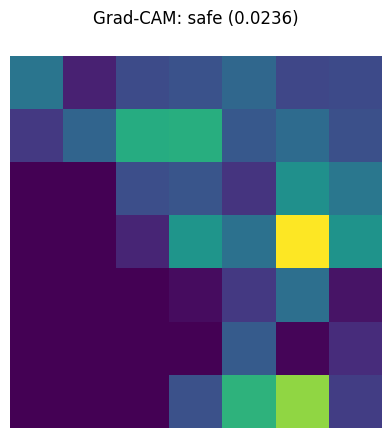

In [21]:
heatmap = make_gradcam_heatmap(img_array, model, "conv5_block3_3_conv")
plt.matshow(heatmap)
plt.title(f"Grad-CAM: {predicted_class} ({confidence:.4f})")
plt.axis('off')
plt.show()

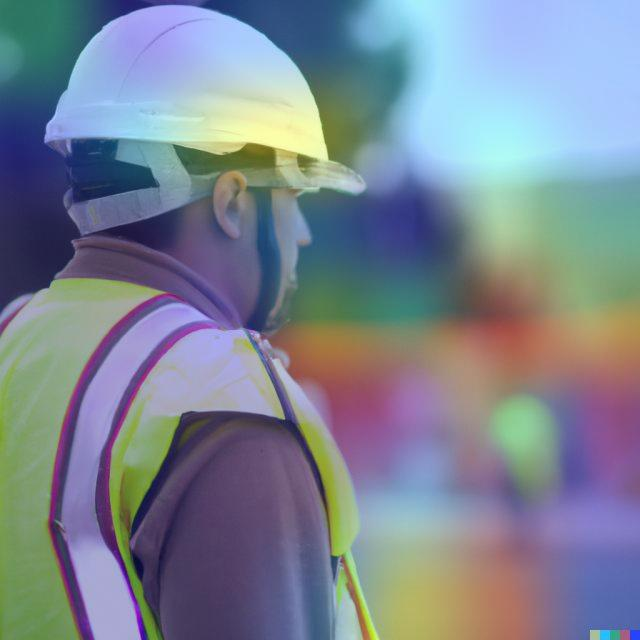

In [22]:
import matplotlib as mpl
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.5):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create image with RGB color
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = image.array_to_img(Superimposed_img)

    # Save the superimposed image
    Superimposed_img.save(cam_path)

    # Displaying Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)